<img width = 85% src='rapids_motivation.png'>

<img width = 75% src='choices.png'>

### Overview 
1 -- synthetically generate a learning problem [ classification ]

2 -- go through a data science pipeline [ pre-processing , splitting , viz ]

3 -- model building [ xgboost ]
> hyper-parameters [ max-depth, nTrees, learning rage, regularization ... ]

> demonstrate performance [ CPU vs 1 GPU ]

4 -- scaling and hyper-parameter search
> dask + rapids [ xgboost ]
    
5 -- visualize search and reveal best model parameters

TODO - generate figures that caputre benefit of GPU scaling

6 -- extensions[ multi-node [ dask kubernetes ], dask_xgboost [ larger dataset ] ]

In [1]:
import numpy as np; import numpy.matlib

In [2]:
import ipyvolume as ipv

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# algos, datasets
import xgboost; from xgboost import plot_tree
from sklearn import datasets; from sklearn.metrics import confusion_matrix, accuracy_score

In [5]:
import cupy
import cudf

In [6]:
import time

In [7]:
import rapids_lib_v9 as rl
''' NOTE: anytime changes are made to rapids_lib.py you can either:
      1. refresh/reload via the code below, OR
      2. restart the kernel '''
import importlib; importlib.reload(rl)

<module 'rapids_lib_v9' from '/rapids/notebooks/rapids/HPO/rapids_lib_v9.py'>

# Data Generation

We will generate data shapes [coordinate lists] and hand them to the GPU. The GPU will randomly build 3D blobs [ cupy.random.normal ] around each coordinate point to create a much larger, noisier, and more realistic dataset.

In [8]:
coilPoints = rl.gen_coil( nPoints = 20, coilDensity = 5 )

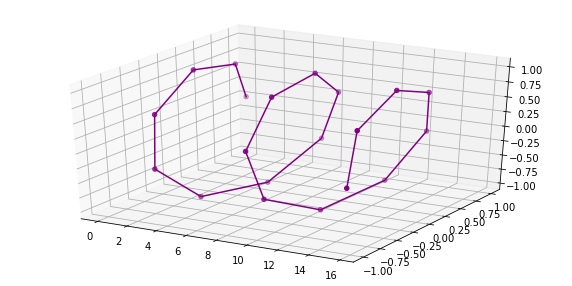

In [9]:
ax = plt.figure( figsize = ( 10, 5 )).add_subplot(111, projection='3d')
ax.plot( coilPoints[:,0], coilPoints[:,1], coilPoints[:,2], 'purple')
ax.scatter( coilPoints[:,0], coilPoints[:,1], coilPoints[:,2], color='purple')
plt.show()

Using this concept we offer the following dataset variations:
1. Helix - two entwined coils, inspired by DNA casing
2. Whirl - an increasingly unwinding Helix 

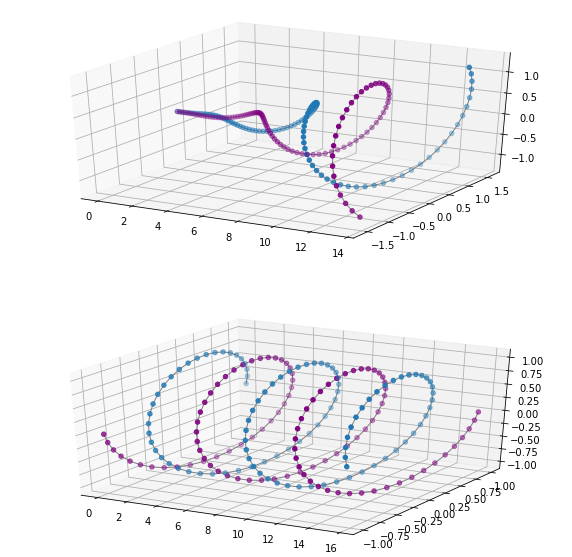

In [10]:
rl.plot_dataset_variants()

# Helix and Whirl Datasets

In [121]:
nBlobPoints = 500
nCoordinates = 200
sdevScales = [ .4, .4, .4]
noiseScale = 1/6.
coilDensity = 12

In [122]:
data, labels, t_gen = rl.gen_blob_coils( coilType='whirl', shuffleFlag = False, 
                                         nBlobPoints = nBlobPoints,  
                                         nCoordinates = nCoordinates, 
                                         sdevScales = sdevScales, 
                                         noiseScale = noiseScale, 
                                         coilDensity = coilDensity )

generating blobs; # points = 100000
generating blobs; # points = 100000
time to generate data on GPU = 0.19466900825500488
	 plotting data - stride = 2 


In [123]:
data, labels, t_gen = rl.gen_blob_coils( coilType='helix', shuffleFlag = False, 
                                         nBlobPoints = nBlobPoints,  
                                         nCoordinates = nCoordinates, 
                                         sdevScales = sdevScales, 
                                         noiseScale = noiseScale, 
                                         coilDensity = coilDensity )

generating blobs; # points = 100000
generating blobs; # points = 100000
time to generate data on GPU = 0.1635723114013672
	 plotting data - stride = 2 


# Split train and test data 

In [124]:
expLog = {}

In [125]:
def split_train_test_nfolds ( dataDF, labelsDF, nFolds = 10, seed = 1, nSamplesToSwap = 50 ):
    print('splitting data into training and test set')
    startTime = time.time()
    
    nSamplesPerFold = int(dataDF.shape[0] // nFolds)
    sampleRanges = np.arange(nFolds) * nSamplesPerFold
        
    np.random.seed(seed)
    foldStartInds = np.random.randint(0, nFolds-1, size = nFolds)
    foldEndInds = foldStartInds + 1 
    
    testFold = np.random.randint(0,nFolds-1)
    trainInds = None; testInds = None
    
    for iFold in range( nFolds ):
        lastFoldFlag = ( iFold == nFolds-1 )
        if lastFoldFlag: foldInds = np.arange(sampleRanges[iFold], dataDF.shape[0] )
        else: foldInds = np.arange(sampleRanges[iFold], sampleRanges[iFold+1])
        
        if iFold == testFold: testInds = foldInds
        else:
            if trainInds is None: trainInds = foldInds
            else: trainInds = np.concatenate([trainInds, foldInds])
                
    # swap subset of train and test samples [ low values require higher model generalization ]
    if nSamplesToSwap > 0:
        trainIndsToSwap = np.random.permutation(trainInds.shape[0])[0:nSamplesToSwap]
        testIndsToSwap = np.random.permutation(testInds.shape[0])[0:nSamplesToSwap]        
        trainBuffer = trainInds[trainIndsToSwap].copy()
        trainInds[trainIndsToSwap] = testInds[testIndsToSwap]
        testInds[testIndsToSwap] = trainBuffer
    
    # build final dataframes
    trainDF = dataDF.iloc[trainInds]
    testDF = dataDF.iloc[testInds]
    trainLabelsDF = labelsDF.iloc[trainInds]
    testLabelsDF = labelsDF.iloc[testInds]                
    
    return trainDF, trainLabelsDF, testDF, testLabelsDF, time.time() - startTime

## 3.2 Rescale/Normalize

In [126]:
def scale_dataframe_inplace ( targetDF, trainMeans = {}, trainSTDevs = {} ):    
    print('rescaling data')
    sT = time.time()
    for iCol in targetDF.columns:
        
        # omit scaling label column
        if iCol == targetDF.columns[-1] == 'label': continue
            
        # compute means and standard deviations for each column [ should skip for test data ]
        if iCol not in trainMeans.keys() and iCol not in trainSTDevs.keys():            
            trainMeans[iCol] = targetDF[iCol].mean()
            trainSTDevs[iCol] = targetDF[iCol].std()
            
        # apply scaling to each column
        targetDF[iCol] = ( targetDF[iCol] - trainMeans[iCol] ) / ( trainSTDevs[iCol] + 1e-10 )
        
    return trainMeans, trainSTDevs, time.time() - sT

### **CPU** split & scale

In [127]:
# split
trainData_pDF, trainLabels_pDF, testData_pDF, testLabels_pDF, t_split_CPU = split_train_test_nfolds ( data.to_pandas(), labels.to_pandas(), nSamplesToSwap = 500 )

# apply standard scaling
trainMeans_CPU, trainSTDevs_CPU, t_scaleTrain_CPU = scale_dataframe_inplace ( trainData_pDF )
_,_, t_scaleTest_CPU = scale_dataframe_inplace ( testData_pDF, trainMeans_CPU, trainSTDevs_CPU )    

expLog = rl.update_log( expLog, [['CPU_split_train_test', t_split_CPU],
                                 ['CPU_scale_train_data', t_scaleTrain_CPU], 
                                 ['CPU_scale_test_data', t_scaleTest_CPU]] )

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ CPU_split_train_test     :   0.01929 s ]
 + adding log entry [ CPU_scale_train_data     :   0.18867 s ]
 + adding log entry [ CPU_scale_test_data      :   0.12738 s ]


### **GPU** split & scale

In [128]:
# split
trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, t_split = split_train_test_nfolds ( data, labels, nSamplesToSwap = 500)

# apply standard scaling
trainMeans, trainSTDevs, t_scaleTrain = scale_dataframe_inplace ( trainData_cDF )
_,_, t_scaleTest = scale_dataframe_inplace ( testData_cDF, trainMeans, trainSTDevs )    

expLog = rl.update_log( expLog, [['GPU_split_train_test', t_split],
                                 ['GPU_scale_train_data', t_scaleTrain],
                                 ['GPU_scale_test_data', t_scaleTest]] ); 

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ GPU_split_train_test     :   0.08932 s ]
 + adding log entry [ GPU_scale_train_data     :   0.00690 s ]
 + adding log entry [ GPU_scale_test_data      :   0.00432 s ]


In [129]:
rl.plot_train_test(trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF)

# Training and Evaluating a Single Model on CPU and GPU

In [130]:
''' -------------------------------------------------------------------------
>  GPU Train and Test
------------------------------------------------------------------------- '''
def train_model_GPU (trainData_cDF, testData_cDF, paramsGPU = {}):    
    print('training xgboost model on GPU');  
    startTime = time.time()    
    
    trainDMatrix = xgboost.DMatrix( trainData_cDF.to_pandas(), label = trainLabels_cDF.to_pandas())    
    trainedModelGPU = xgboost.train( dtrain = trainDMatrix, params = paramsGPU, num_boost_round = paramsGPU['num_boost_rounds'] )
    
    return trainedModelGPU, time.time() - startTime

def test_model_GPU ( trainedModelGPU, testData_cDF, testLabels_cDF ):
    print('testing xgboost model on GPU')
    startTime = time.time()   
    
    testDMatrix = xgboost.DMatrix( data = testData_cDF.to_pandas(), label = testLabels_cDF.to_pandas())    
    predictionsGPU = trainedModelGPU.predict(testDMatrix)
    
    return predictionsGPU, time.time() - startTime

''' -------------------------------------------------------------------------
>  CPU Train and Test
------------------------------------------------------------------------- '''
def train_model_CPU (trainData_cDF, trainLabels_cDF, paramsCPU = {}):    
    print('training xgboost model on {} CPU cores'.format(nCores) )

    startTime = time.time()
    
    trainDMatrix = xgboost.DMatrix( trainData_cDF.to_pandas(), label = trainLabels_cDF.to_pandas())
    
    xgBoostModelCPU = xgboost.train( dtrain = trainDMatrix, params = paramsCPU, num_boost_round = paramsCPU['num_boost_rounds'])
    
    return xgBoostModelCPU, time.time() - startTime

def test_model_CPU ( trainedModelCPU, testData_cDF, testLabels_cDF ):
    print('testing xgboost model on CPU')
    startTime = time.time()
    
    testDMatrix = xgboost.DMatrix( testData_cDF.to_pandas(), label = testLabels_cDF.to_pandas())
    predictionsCPU = trainedModelCPU.predict(testDMatrix)
    
    return predictionsCPU, time.time() - startTime

### Define model parameters
https://xgboost.readthedocs.io/en/latest/parameter.html

In [131]:
nCores = !nproc --all
nCores = int(nCores[0])

paramsCPU = {
    'max_depth': 6,
    'num_boost_rounds': 100,    
    'learning_rate': .1,
    'lambda': 1,    
    'objective': 'binary:hinge',
    'tree_method': 'hist',
    'n_jobs': nCores,
    'random_state': 0
}

paramsGPU = {
    'max_depth': 6,
    'num_boost_rounds': 100,
    'learning_rate': .1,
    'lambda': 1,    
    'objective': 'binary:hinge',
    'tree_method': 'gpu_hist',
    'n_gpus': 1,    
    'random_state': 0
}

### **CPU** Training and Inference

In [132]:
trainedModelCPU, t_trainCPU = train_model_CPU ( trainData_cDF, trainLabels_cDF, paramsCPU )

training xgboost model on 40 CPU cores


In [133]:
predictionsCPU, t_inferCPU = test_model_CPU ( trainedModelCPU, testData_cDF, testLabels_cDF)

testing xgboost model on CPU


In [134]:
expLog = rl.update_log( expLog, [['CPU_model_training', t_trainCPU], ['CPU_model_inference', t_inferCPU]] ); 

 + adding log entry [ CPU_model_training       :   7.67056 s ]
 + adding log entry [ CPU_model_inference      :   0.02088 s ]


### **GPU** Model Training and Inference

In [135]:
trainedModelGPU, t_trainGPU = train_model_GPU ( trainData_cDF, trainLabels_cDF, paramsGPU )

training xgboost model on GPU


In [136]:
predictionsGPU, t_inferGPU = test_model_GPU ( trainedModelGPU, testData_cDF, testLabels_cDF)

testing xgboost model on GPU


In [137]:
expLog = rl.update_log( expLog, [['GPU_model_training', t_trainGPU], ['GPU_model_inference', t_inferGPU]] ); 

 + adding log entry [ GPU_model_training       :   0.45526 s ]
 + adding log entry [ GPU_model_inference      :   0.01315 s ]


### Compare CPU and GPU Accuracy [ plot on train and test ]

In [138]:
trainLabels_pDF = trainLabels_cDF.to_pandas()
testLabels_pDF = testLabels_cDF.to_pandas()

trainPredictionsCPU, _ = test_model_CPU ( trainedModelCPU, trainData_cDF, trainLabels_cDF)
trainPredictionsGPU, _ = test_model_GPU ( trainedModelGPU, trainData_cDF, trainLabels_cDF)
trainAccuracyCPU = accuracy_score(trainLabels_pDF, trainPredictionsCPU)
trainAccuracyGPU = accuracy_score(trainLabels_pDF, trainPredictionsGPU)
print( 'train data CPU accuracy = {}'.format( trainAccuracyCPU ) )
print( 'train data GPU accuracy = {}'.format( trainAccuracyGPU ) )

accuracyCPU = accuracy_score(testLabels_pDF, predictionsCPU)
accuracyGPU = accuracy_score(testLabels_pDF, predictionsGPU)
print( 'test data CPU accuracy = {}'.format( accuracyCPU ) )
print( 'test data GPU accuracy = {}'.format( accuracyGPU ) )

testing xgboost model on CPU
testing xgboost model on GPU
train data CPU accuracy = 0.9688666666666667
train data GPU accuracy = 0.9690722222222222
test data CPU accuracy = 0.57355
test data GPU accuracy = 0.70725


In [139]:
cMat = confusion_matrix(testLabels_pDF, predictionsGPU)
print(cMat)

[[6960 3002]
 [2853 7185]]


### Visualize the first decision tree

CPU times: user 611 ms, sys: 237 ms, total: 848 ms
Wall time: 1.87 s


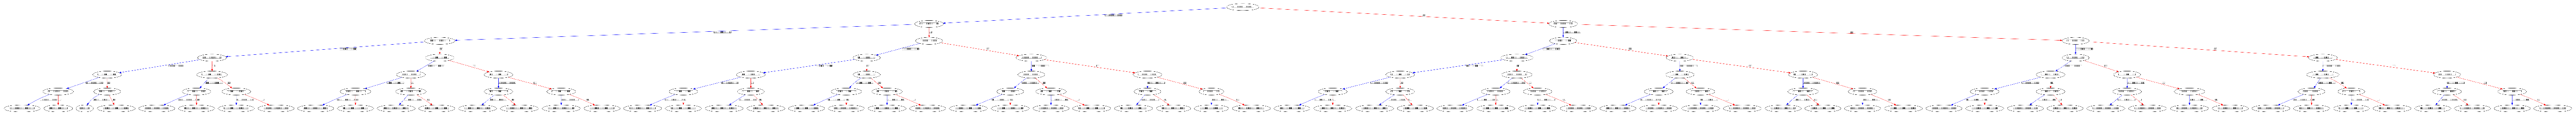

In [140]:
%%time
fig = plt.figure(figsize=(100,50))
plot_tree(trainedModelGPU, num_trees=0, ax=plt.subplot(1,1,1))

In [141]:
expLog

{'CPU_split_train_test': 0.019292593002319336,
 'CPU_scale_train_data': 0.18866562843322754,
 'CPU_scale_test_data': 0.12738442420959473,
 'GPU_split_train_test': 0.08931636810302734,
 'GPU_scale_train_data': 0.0068950653076171875,
 'GPU_scale_test_data': 0.00432276725769043,
 'CPU_model_training': 7.670556545257568,
 'CPU_model_inference': 0.02088475227355957,
 'GPU_model_training': 0.45526123046875,
 'GPU_model_inference': 0.013147354125976562}

# Parameter Search          
> TODO: ADD early stopping 

### Initialize Dask

In [32]:
import dask
from dask import delayed
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

In [33]:
import xgboost;
print( xgboost.__version__ )

0.90.rapidsdev1


### Set number of workers [ changes require kernel restart ]

In [34]:
cluster = LocalCUDACluster(ip="", n_workers = 4 )
client = Client(cluster)

In [35]:
client

Client Scheduler: tcp://172.17.0.2:35157 Dashboard: http://172.17.0.2:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


In [36]:
cluster

### Pre-scatter Demo

In [37]:
if client is not None:        
    scatteredData_future = client.scatter( [ trainData_cDF, testData_cDF ], broadcast = True)

In [38]:
scatteredData_future

[<Future: status: finished, type: DataFrame, key: DataFrame-67d6ab443e9bf7155e8b79e201f186b8>,
 <Future: status: finished, type: DataFrame, key: DataFrame-288798c3b14f2278c284529ff4c9199a>]

In [39]:
print ( '{} \n {} \n'.format( scatteredData_future[0].key, scatteredData_future[1].key ) )
client.who_has(scatteredData_future)

DataFrame-67d6ab443e9bf7155e8b79e201f186b8 
 DataFrame-288798c3b14f2278c284529ff4c9199a 



{'DataFrame-288798c3b14f2278c284529ff4c9199a': ('tcp://172.17.0.2:36159',
  'tcp://172.17.0.2:34561',
  'tcp://172.17.0.2:44331',
  'tcp://172.17.0.2:38615'),
 'DataFrame-67d6ab443e9bf7155e8b79e201f186b8': ('tcp://172.17.0.2:36159',
  'tcp://172.17.0.2:34561',
  'tcp://172.17.0.2:44331',
  'tcp://172.17.0.2:38615')}

## HPO Strategy - Particle Swarm [ Explore + Exploit ]

In [142]:
def update_particles( paramRanges, particlesInTimestep, velocitiesInTimestep, bestParamsIndex, globalBestParams, sBest = .75, sExplore = .25 , deltaTime = 1):
    
    nParticles = particlesInTimestep.shape[ 0 ]
    nParameters = particlesInTimestep.shape[ 1 ]
    # best = particlesInTimestep[bestParamsIndex, :]
    
    #bestRep = numpy.matlib.repmat( np.array( best ).reshape( -1, 1 ), nParticles, 1).reshape( nParticles, nParameters )
    bestRep = numpy.matlib.repmat( np.array( globalBestParams ).reshape( -1, 1 ), nParticles, 1).reshape( nParticles, nParameters )
    
    # momentum + move to best + explore
    velocitiesInTimestep += sBest * ( bestRep - particlesInTimestep ) \
                            + sExplore * ( np.random.randn( nParticles, nParameters ) )
    
    particlesInTimestep += velocitiesInTimestep * deltaTime 
    
    # TODO: avoid duplicates
    
    # enforce param bounds
    for iParam in range( nParameters ):
        particlesInTimestep[ :, iParam ] = np.clip(particlesInTimestep[ :, iParam ], paramRanges[iParam][1], paramRanges[iParam][2])
        if paramRanges[iParam][3] == 'int':
            particlesInTimestep[ :, iParam ] = np.round( particlesInTimestep[ :, iParam ] )
            
    return particlesInTimestep, velocitiesInTimestep
    

## HPO Harness
> Particle Evals [ Train and Test Logic ]

In [143]:
def train_model_hpo ( trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, particleParams, iParticle, iTimestep ):
    
    # fixed parameters
    paramsGPU = { 'objective': 'binary:hinge',
                  'tree_method': 'gpu_hist',
                  'n_gpus': 1,
                  'random_state': 0 }
    
    # parameters to search over
    paramsGPU['max_depth'] = int(particleParams[0])
    paramsGPU['learning_rate'] = particleParams[1]
    paramsGPU['lambda'] = particleParams[2] 
    paramsGPU['num_boost_rounds'] = 1000
    
    startTime = time.time()
    trainDMatrix = xgboost.DMatrix( data = trainData_cDF, label = trainLabels_cDF )
    testDMatrix = xgboost.DMatrix( data = testData_cDF, label = testLabels_cDF )
    trainedModelGPU = xgboost.train( dtrain = trainDMatrix, evals = [(testDMatrix, 'test')], 
                                     params = paramsGPU,
                                     num_boost_round = paramsGPU['num_boost_rounds'],
                                     early_stopping_rounds = 15,
                                     verbose_eval = False )
    
    elapsedTime = time.time() - startTime
    print('training xgboost model on GPU t: {}, nP: {}, params [  {} {} {} ], time: {} '.format( iTimestep, iParticle, particleParams[0], particleParams[1], particleParams[2], elapsedTime) );  
    return trainedModelGPU, elapsedTime

def test_model_hpo ( trainedModelGPU, trainingTime, testData_cDF, testLabels_cDF ):
    
    startTime = time.time()
    
    testDMatrix = xgboost.DMatrix( data = testData_cDF, label = testLabels_cDF )    
    predictionsGPU = trainedModelGPU.predict( testDMatrix ).astype(int)
    
    return predictionsGPU, trainedModelGPU.best_iteration, trainingTime, time.time() - startTime

In [144]:
def run_hpo ( daskClient, nTimesteps, nParticles, nWorkers, paramRanges, trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, randomSeed = 0):
    
    pandasTestLabels = testLabels_cDF.to_pandas()

    if daskClient is not None:        
        scatteredData_future = daskClient.scatter( [ trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF ], broadcast = True )
    
    trainData_cDF_future = scatteredData_future[0]; trainLabels_cDF_future = scatteredData_future[1]
    testData_cDF_future = scatteredData_future[2]; testLabels_cDF_future = scatteredData_future[3]
    
    particles, velocities, accuracies, bestParticleIndex, \
        globalBestParticleParams, particleBoostingRounds, particleColors = rl.initalize_hpo ( nTimesteps = nTimesteps, 
                                                                                              nParticles = nParticles, 
                                                                                              nWorkers = nWorkers, 
                                                                                              paramRanges = paramRanges)
    globalBestAccuracy = 0
    
    trainingTimes = np.zeros (( nTimesteps, nParticles ))    
    startTime = time.time()
    
    for iTimestep in range (0, nTimesteps ):    
        if daskClient is not None:
            # [ delayed ] train xgboost models on train data
            delayedParticleTrain = [ delayed( train_model_hpo )( trainData_cDF_future, trainLabels_cDF_future, 
                                                                     testData_cDF_future, testLabels_cDF_future, 
                                                                     particles[iTimestep, iParticle, : ], 
                                                                         iParticle, iTimestep) for iParticle in range(nParticles) ]

            # [ delayed ] determine number of trees/training-rounds returned early stopping -- used to set particle sizes
            delayedParticleRounds = [ iParticle[0].best_iteration for iParticle in delayedParticleTrain ]
            
            # [delayed ] eval trained models on test/validation data
            delayedParticlePredictions = [ delayed( test_model_hpo )(iParticle[0], iParticle[1], 
                                                                         testData_cDF_future, testLabels_cDF_future) for iParticle in delayedParticleTrain ]
                        
            # execute delayed             
            particlePredictions = dask.compute( delayedParticlePredictions )[0]            
            
            # compute accuracies of predictions
            accuracies[iTimestep, :] = [ accuracy_score ( pandasTestLabels, iParticle[0]) for iParticle in particlePredictions ]
            particleBoostingRounds[iTimestep, : ] = [ iParticle[1] for iParticle in particlePredictions ]
            trainingTimes[iTimestep, :] = [ iParticle[2] for iParticle in particlePredictions ]
            
        else:
            for iParticle in range(nParticles):
                trainedModels, _ = train_model_hpo ( pandasTrainData, pandasTrainLabels, particles[iTimestep, iParticle, : ], iParticle, iTimestep)
                predictions, _ = test_model_hpo( trainedModels, pandasTestData, pandasTestLabels)            
                accuracies[iTimestep, iParticle] = accuracy_score (pandasTestLabels, predictions)
        
        bestParticleIndex[iTimestep+1] = np.argmax( accuracies[iTimestep, :] )
        currentBestAccuracy = np.max( accuracies[iTimestep, :] )

        print('@ hpo timestep : {}, best accuracy is {}'.format(iTimestep, np.max(accuracies[iTimestep, :])) )
        if iTimestep +1 < nTimesteps:
            
            if currentBestAccuracy > globalBestAccuracy:
                globalBestAccuracy = currentBestAccuracy
                globalBestParticleParams[iTimestep+1] = particles[iTimestep, bestParticleIndex[iTimestep+1], :]
            else:
                globalBestParticleParams[iTimestep+1] = globalBestParticleParams[iTimestep].copy()
            
            particles[iTimestep+1, :, :], velocities[iTimestep+1, :, : ] = update_particles ( paramRanges, 
                                                                                              particles[iTimestep, :, :].copy(),
                                                                                              velocities[iTimestep, :, :].copy(), 
                                                                                              bestParticleIndex[iTimestep+1], 
                                                                                              globalBestParticleParams[iTimestep+1])
    
    particleSizes = particleBoostingRounds/np.max(particleBoostingRounds)*10 + 2
    elapsedTime = time.time() - startTime
    print( 'elapsed time : {}'.format(elapsedTime) )
    
    return accuracies, particles, velocities, particleSizes, particleColors, bestParticleIndex, particleBoostingRounds, trainingTimes, elapsedTime

## Settings for HPO

In [145]:
nTimesteps = 10
nWorkers = 4
nParticles = 2*nWorkers**2

In [146]:
paramRanges = { 0: ['max_depth', 3, 15, 'int'],
                1: ['learning_rate', .01, 10, 'float'],
                2: ['lambda', .01, 30, 'float'] }

### Run HPO

In [147]:
accuracies, particles, velocities, particleSizes, particleColors, \
bestParticleIndex, particleBoostingRounds, trainingTimes, elapsedTime = run_hpo ( client, nTimesteps, 
                                                                                  nParticles,
                                                                                  nWorkers,
                                                                                  paramRanges, 
                                                                                  trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF )

@ hpo timestep : 0, best accuracy is 0.77935
@ hpo timestep : 1, best accuracy is 0.8443
@ hpo timestep : 2, best accuracy is 0.8348
@ hpo timestep : 3, best accuracy is 0.8051
@ hpo timestep : 4, best accuracy is 0.83215
@ hpo timestep : 5, best accuracy is 0.8309
@ hpo timestep : 6, best accuracy is 0.822
@ hpo timestep : 7, best accuracy is 0.82295
@ hpo timestep : 8, best accuracy is 0.8391
@ hpo timestep : 9, best accuracy is 0.83145
elapsed time : 57.125930070877075


### Find top performing parameter settings

In [148]:
bestParamIndex = np.unravel_index(np.argmax(accuracies, axis=None), accuracies.shape)

In [149]:
# best accuracy
print('highest accuracy               :  {} '.format(accuracies[bestParamIndex[0], bestParamIndex[1]], bestParamIndex[0]+1))
print('   @ timestep {}, particle {} '.format( bestParamIndex[0], bestParamIndex[1]))

print('\nbest model tree depth          :  {} '.format(particles[bestParamIndex[0], bestParamIndex[1], 0]))
print('best model learning rate       :  {} '.format(particles[bestParamIndex[0], bestParamIndex[1], 1]))
print('best model regularization      :  {} '.format(particles[bestParamIndex[0], bestParamIndex[1], 2]))
print('best model num boosting rounds :  {} '.format(int(particleBoostingRounds[bestParamIndex[0], bestParamIndex[1]])))


highest accuracy               :  0.8443 
   @ timestep 1, particle 19 

best model tree depth          :  9.0 
best model learning rate       :  7.7855170918365 
best model regularization      :  15.292262981265788 
best model num boosting rounds :  21 


### Visualize search

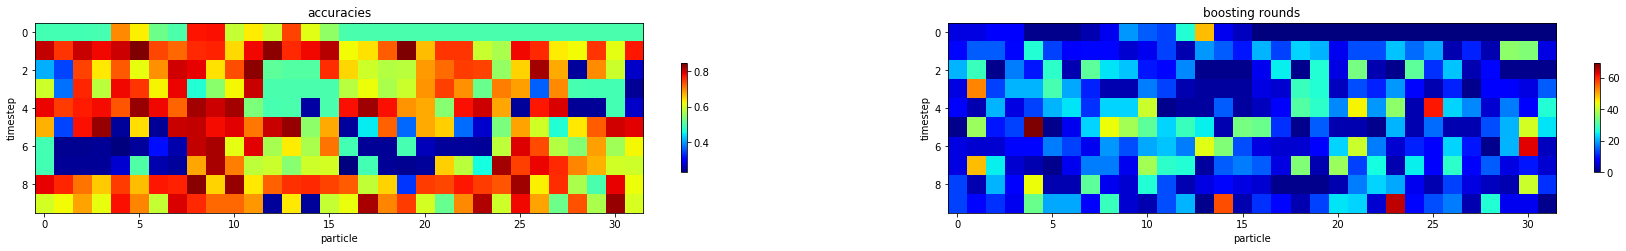

In [150]:
rl.viz_search( accuracies, particleBoostingRounds )

In [151]:
rl.hpo_animate (particles, particleSizes, particleColors, paramRanges, nTimesteps = 15 )

In [ ]:
# TODO use best model params to train a model [ & visualize its mistakes ]

## Appendix

### Dask restart

In [ ]:
# forces workers to restart. useful to ensure GPU memory is clear
client.restart()

# limit work-stealing as much as possible
dask.config.set({'distributed.scheduler.work-stealing': False})
dask.config.get('distributed.scheduler.work-stealing')
dask.config.set({'distributed.scheduler.bandwidth': 1})
dask.config.get('distributed.scheduler.bandwidth')

client

<img src='https://upload.wikimedia.org/wikipedia/commons/e/ec/ParticleSwarmArrowsAnimation.gif'>